# Notebook for the first baseline model 
Starting with PCA embeddings of RNA, using Linear Regression to predict how a clone responses to vaccination in a late time point, using data from P1 (initial time point) to predcit S1 and T1  
Random pairing


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import pandas as pd
import numpy as np
import scirpy as ir
import anndata as ad
import scanpy as sc
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor 
import matplotlib.pyplot as plt
import moscot
from sklearn.metrics import mean_squared_error, r2_score

/Users/tristanaretz/mambaforge/envs/vaccineSimulator/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Get data & explore data

In [3]:
adata = sc.read_h5ad('../../../data/combined/02_dex_annotated_cd8_mvTCR_PCA.h5ad')
adata

AnnData object with n_obs × n_vars = 44310 × 50
    obs: '%_max_dextramer', 'ATDSLNNEY', 'C0251_A02', 'C0251_A08', 'C0252_A03', 'C0252_A04', 'C0253_A04', 'C0253_A05', 'C0254_A05', 'C0254_A11', 'C0255_A06', 'C0255_A15', 'C0256_A11', 'C0256_A29', 'C0257_A15', 'C0257_A19', 'C0258_A25', 'C0258_A29', 'CCR7', 'CD4 NV/CM_score', 'CD4/CD8_score', 'CD45RA', 'CD62L', 'CD8 Cytokine_score', 'CD8 Cytotoxic_score', 'CTELKLSDY', 'CXCR3', 'FLRGRAYGL', 'FPQSAPHGV', 'GTHWFVTQR', 'HA1', 'HA2', 'HA3', 'HA4', 'HA5', 'HA6', 'HA7', 'HA8', 'Hu.CD101', 'Hu.CD103', 'Hu.CD105_43A3', 'Hu.CD107a', 'Hu.CD112', 'Hu.CD119', 'Hu.CD11a', 'Hu.CD11b', 'Hu.CD11c', 'Hu.CD122', 'Hu.CD123', 'Hu.CD124', 'Hu.CD127', 'Hu.CD13', 'Hu.CD134', 'Hu.CD137', 'Hu.CD141', 'Hu.CD146', 'Hu.CD14_M5E2', 'Hu.CD152', 'Hu.CD154', 'Hu.CD155', 'Hu.CD158', 'Hu.CD158b', 'Hu.CD158e1', 'Hu.CD16', 'Hu.CD161', 'Hu.CD163', 'Hu.CD169', 'Hu.CD18', 'Hu.CD183', 'Hu.CD185', 'Hu.CD19', 'Hu.CD194', 'Hu.CD195', 'Hu.CD196', 'Hu.CD1c', 'Hu.CD1d', 'Hu.CD2', 'Hu.C

In [4]:
print((adata.obs["time"] == "P1").sum())
print((adata.obs["time"] == "S1").sum())
print((adata.obs["time"] == "T1").sum())

8451
10470
8495


In [5]:
adata.obs

,%_max_dextramer,ATDSLNNEY,C0251_A02,C0251_A08,C0252_A03,C0252_A04,C0253_A04,C0253_A05,C0254_A05,C0254_A11,...,time,v_genes,clonotype,clonotype_size,alpha_len,beta_len,set,IFN_Response_score_bin,Responder,gene_average
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGTGTTGAA-1-initial-0-0,0.750000,NaN,10.0,NaN,3.0,NaN,3.0,NaN,0.0,NaN,...,S2,TRAV26-1 TRBV4-1,0,1,11,14,val,high,True,0.061717
AAACCTGCACCAGGCT-1-initial-0-0,1.000000,NaN,7.0,NaN,3.0,NaN,11.0,NaN,0.0,NaN,...,S2,TRAV8-3 TRBV5-8,1,1,14,14,train,low,False,0.517519
AAACCTGCATACGCTA-1-initial-0-0,0.514852,NaN,21.0,NaN,8.0,NaN,12.0,NaN,2.0,NaN,...,S2,TRAV13-1 TRBV18,2,12,15,11,train,high,True,-0.108923
AAACGGGGTACGAAAT-1-initial-0-0,0.357143,NaN,35.0,NaN,1.0,NaN,8.0,NaN,0.0,NaN,...,S2,TRAV8-6 TRBV7-6,3,46,15,17,train,medium-high,False,-0.124566
AAACGGGGTATTAGCC-1-initial-0-0,0.428571,NaN,10.0,NaN,9.0,NaN,5.0,NaN,3.0,NaN,...,S2,TRAV25 TRBV10-3,4,1,12,15,train,medium-high,False,-0.080338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCGCTCTCTGAGA-1-2-1,0.526316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,T1,TRAV12-1 TRBV10-3,13714,1,10,13,val,medium-low,False,0.551563
TTTGGTTGTTCGGGCT-1-2-1,0.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,T1,TRAV1-2 TRBV20-1,7144,5,12,15,train,medium-high,False,-0.642435
TTTGGTTTCCACGACG-1-2-1,0.625000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,S1,TRAV30 TRBV12-3,786,1090,12,14,val,medium-low,False,0.070831


# Creat RNA Embeddings with PCA
Here, the sc.tl.pca was utlized, with manually selecting the number of principal components with the use of a variance ratio plot. Alternatively, one could use sklearn.PCA  
PCA embeddings are saved automatically in adata.obsm["X_pca"]

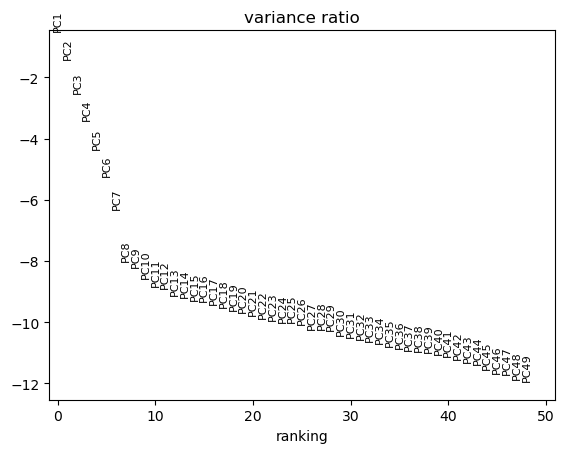

In [6]:
pca_adata = adata.copy()
sc.tl.pca(pca_adata)
sc.pl.pca_variance_ratio(pca_adata, log=True, n_pcs=50) # Elbow plot

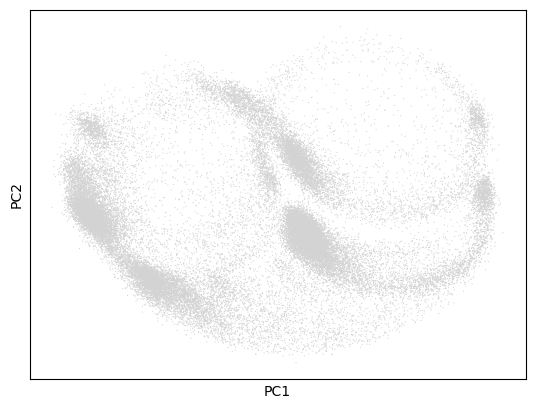

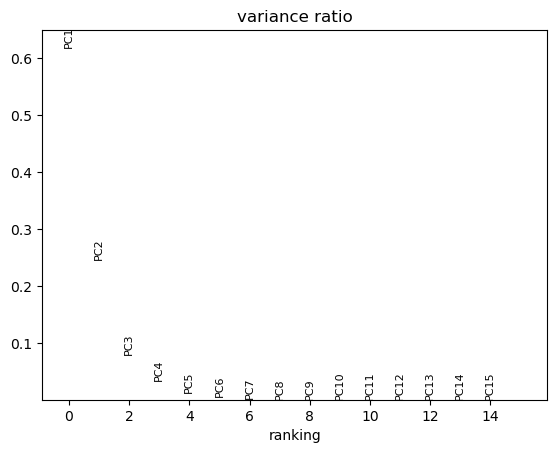

In [7]:
sc.tl.pca(adata, n_comps=15) # Perform PCA -> use 15 components since they explain 90% of the variance (plot)
sc.pl.pca(adata) # Plot only the top two principal components as they are most informative
sc.pl.pca_variance_ratio(adata, n_pcs=15) 

# Clone Aggregation and Pairing:
For each clone early and late time point data is paired.
Not all clones in P1 might exist in S1 or T1. Here, we ensure that only clones with valid response scores are included in the model training.

In [8]:
# filter out cells that we can't use
adata = adata[~adata.obs.clone_id.isna()]
adata = adata[~(adata.obs.clone_id=='nan')]
adata = adata[~(adata.obs.time.isin(['X3','extra']))]

In [9]:
# Filter for time points
P1_mask = adata.obs["time"] == "P1"
S1_mask = adata.obs["time"] == "S1"
T1_mask = adata.obs["time"] == "T1"

# Features: Embeddings from P1
X = adata[P1_mask].obsm['emb_mvTCR_PCA']

# get target variable and clones from S1 and T1
S1_clones = adata[S1_mask].obs["clone_id"].values  # Clonotypes at S1
S1_targets = adata[S1_mask].obs["IFN Response_score"].values # target variable

T1_clones = adata[T1_mask].obs["clone_id"].values  # Clonotypes at T1
T1_targets = adata[T1_mask].obs["IFN Response_score"].values # target variable

P1_clones = adata[P1_mask].obs["clone_id"].values
P1_targets = adata[P1_mask].obs["IFN Response_score"].values    

unique_clonotypes_aggregated = np.unique(P1_clones) # Unique clonotypes in the aggregated data

In [10]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import smogn

In [11]:
# alternative: random pairing of cells - baseline model
# Random pairing of cells
random_indices_s1 = np.random.permutation(len(S1_targets))
random_indices_t1 = np.random.permutation(len(T1_targets))

# Shuffle and align S1 and T1 responses with P1 clones randomly
s1_random = S1_targets[random_indices_s1[:len(P1_clones)]]
t1_random = T1_targets[random_indices_t1[:len(P1_clones)]]

# Aggregate features for training
X_aggregated = []
y_s1_aggregated = []
y_t1_aggregated = []

for clone in np.unique(P1_clones):
    mask = P1_clones == clone  # Select rows for the current clone
    X_aggregated.append(X[mask].mean(axis=0))  # Mean of features
    y_s1_aggregated.append(s1_random[mask].mean())  # Randomized S1 response
    y_t1_aggregated.append(t1_random[mask].mean())  # Randomized T1 response

# Convert to arrays
X_aggregated = np.array(X_aggregated)
y_s1_aggregated_baseline = np.array(y_s1_aggregated)
y_t1_aggregated_baseline = np.array(y_t1_aggregated)

In [12]:
X_s1_train, X_s1_test, y_s1_train, y_s1_test = train_test_split(
    X_aggregated, y_s1_aggregated_baseline, test_size=0.2, random_state=42
)

X_t1_train, X_t1_test, y_t1_train, y_t1_test = train_test_split(
    X_aggregated, y_t1_aggregated_baseline, test_size=0.2, random_state=42
)

# Oversampling

In [156]:
# Define feature names for creating DataFrames
feature_names = [f'feature_{i}' for i in range(X_s1_train.shape[1])]

In [157]:
k_smogn = 5
samp_method_smogn = 'balance'
rel_thres_smogn = 0.6

rg_mtrx = [
    [0.0, 0, 0],    # At score 0.0, relevance is 0 (not minority)
    [0.69, 0, 0],   # Up to 0.59, relevance stays 0
    [0.7, 1, 0],    # At 0.6, relevance jumps to 1 (minority)
    [3, 1, 0]     # Up to 1.0, relevance remains 1
]

# rg_mtrx = [
#     [0.0,   1, 1],    # At 0.0, no oversampling, no undersampling (keep all)
#     [0.59,  1, 1],    # Up to 0.59, keep all samples as is
#     [0.6,   1, 1],    # At 0.6, start oversampling (e.g., by a factor of 2), no undersampling
#     [4.0,   1, 1]     # Up to 1.0, maintain the oversampling factor for minority, and do not undersample majority
# ]

In [158]:
### --- For S1 Predictions ---

# Create DataFrame for S1 data
df_s1 = pd.DataFrame(X_s1_train, columns=feature_names)
df_s1['target'] = y_s1_train
df_s1 = df_s1.dropna()

# Apply SMOGN oversampling for regression on S1 data.
# Adjust the parameters (e.g., rel_thres) based on your data distribution.
df_s1_resampled = smogn.smoter(
    data=df_s1,
    y='target',
    k=k_smogn,
    samp_method=samp_method_smogn,  # oversample the extreme target values
    rel_thres=rel_thres_smogn,          # relevance threshold (tune this parameter)
    rel_method='manual',      # let SMOGN automatically compute relevance scores
    drop_na_row=True,
    rel_ctrl_pts_rg = rg_mtrx
)

# Separate features and target for S1
X_s1_resampled = df_s1_resampled.drop(columns=['target']).values
y_s1_resampled = df_s1_resampled['target'].values

# Train a regression model on the resampled S1 data
model_s1 = LinearRegression()
model_s1.fit(X_s1_resampled, y_s1_resampled)

# Predict on the S1 test set
y_s1_pred = model_s1.predict(X_s1_test)

r_index: 100%|##########| 34/34 [00:00<00:00, 1225.68it/s]


In [159]:
### --- For T1 Predictions ---

# Create DataFrame for T1 data
df_t1 = pd.DataFrame(X_t1_train, columns=feature_names)
df_t1['target'] = y_t1_train
df_t1 = df_t1.dropna()

# Apply SMOGN oversampling for regression on T1 data.
df_t1_resampled = smogn.smoter(
    data=df_t1,
    y='target',
    k=k_smogn,
    samp_method=samp_method_smogn,  # oversample the extreme target values
    rel_thres=rel_thres_smogn,          # relevance threshold (tune this parameter)
    rel_method='manual',      # let SMOGN automatically compute relevance scores
    drop_na_row=True,
    rel_ctrl_pts_rg = rg_mtrx
)

# Separate features and target for T1
X_t1_resampled = df_t1_resampled.drop(columns=['target']).values
y_t1_resampled = df_t1_resampled['target'].values

# Train a regression model on the resampled T1 data
model_t1 = LinearRegression()
model_t1.fit(X_t1_resampled, y_t1_resampled)

# Predict on the T1 test set
y_t1_pred = model_t1.predict(X_t1_test)

dist_matrix:   0%|          | 0/178 [00:00<?, ?it/s]

r_index: 100%|##########| 72/72 [00:00<00:00, 1606.69it/s]


In [160]:
### --- Evaluation ---

k = 5

# Evaluate S1 predictions
mse_s1 = mean_squared_error(y_s1_test, y_s1_pred)
mean_clonotype_activation_s1_predicted = y_s1_pred.mean()  # Predicted mean activation
mean_clonotype_activation_s1 = y_s1_test.mean()            # True mean activation
recall_ks1 = recall_at_k(y_s1_test, y_s1_pred, k)          # Assumes recall_at_k is defined

print(f"Recall@{k} for S1: {recall_ks1:.2f}")
print(f"MSE for S1: {mse_s1}")
print(f"Mean Clonotype Activation (S1): {mean_clonotype_activation_s1:.4f}")
print(f"Mean Clonotype Activation (S1) Predicted: {mean_clonotype_activation_s1_predicted:.4f}")

# Evaluate T1 predictions
mse_t1 = mean_squared_error(y_t1_test, y_t1_pred)
recall_kt1 = recall_at_k(y_t1_test, y_t1_pred, k)
mean_clonotype_activation_t1 = y_t1_test.mean()
mean_clonotype_activation_t1_predicted = y_t1_pred.mean()

print(f"Recall@{k} for T1: {recall_kt1:.2f}")
print(f"MSE for T1: {mse_t1}")
print(f"Mean Clonotype Activation (T1): {mean_clonotype_activation_t1:.4f}")
print(f"Mean Clonotype Activation (T1) Predicted: {mean_clonotype_activation_t1_predicted:.4f}")

Recall@5 for S1: 0.00
MSE for S1: 0.16528473303742502
Mean Clonotype Activation (S1): -0.0068
Mean Clonotype Activation (S1) Predicted: 0.3011
Recall@5 for T1: 0.00
MSE for T1: 0.13887150863586417
Mean Clonotype Activation (T1): 0.1202
Mean Clonotype Activation (T1) Predicted: 0.2609


In [161]:
print(f"{recall_ks1:.2f}")
print(f"{mse_s1:.4f}")
print(f"{mean_clonotype_activation_s1:.4f}")
print(f"{mean_clonotype_activation_s1_predicted:.4f}")

print(f"{recall_kt1:.2f}")
print(f"{mse_t1:.4f}")
print(f"{mean_clonotype_activation_t1:.4f}")
print(f"{mean_clonotype_activation_t1_predicted:.4f}")

0.00
0.1653
-0.0068
0.3011
0.00
0.1389
0.1202
0.2609


# Baseline Model with random cell pairing

In [174]:
from sklearn.linear_model import LinearRegression
# alternative: random pairing of cells - baseline model
# Random pairing of cells
random_indices_s1 = np.random.permutation(len(S1_targets))
random_indices_t1 = np.random.permutation(len(T1_targets))

# Shuffle and align S1 and T1 responses with P1 clones randomly
s1_random = S1_targets[random_indices_s1[:len(P1_clones)]]
t1_random = T1_targets[random_indices_t1[:len(P1_clones)]]

# Aggregate features for training
X_aggregated = []
y_s1_aggregated = []
y_t1_aggregated = []

for clone in np.unique(P1_clones):
    mask = P1_clones == clone  # Select rows for the current clone
    X_aggregated.append(X[mask].mean(axis=0))  # Mean of features
    y_s1_aggregated.append(s1_random[mask].mean())  # Randomized S1 response
    y_t1_aggregated.append(t1_random[mask].mean())  # Randomized T1 response

# Convert to arrays
X_aggregated = np.array(X_aggregated)
y_s1_aggregated_baseline = np.array(y_s1_aggregated)
y_t1_aggregated_baseline = np.array(y_t1_aggregated)

## Train Models
For the first baseline model, a Linear Regression is used, since our goal is to predict a numerical and continuous output value  (=IFN score) based on the input features. One can furthermore tune the parameters to improve this model. 

Possible Arcitectures for future models:
- RandomForest
- SVMs
- NNs

### Baseline model

In [13]:
# Train-test split (using sklearn's train_test_split)
from sklearn.model_selection import train_test_split

X_s1_train, X_s1_test, y_s1_train, y_s1_test = train_test_split(
    X_aggregated, y_s1_aggregated_baseline, test_size=0.2, random_state=42
)

X_t1_train, X_t1_test, y_t1_train, y_t1_test = train_test_split(
    X_aggregated, y_t1_aggregated_baseline, test_size=0.2, random_state=42
)

# Train baseline model to predict S1 response
baseline_model_s1 = LinearRegression()
baseline_model_s1.fit(X_s1_train, y_s1_train)

# Predict S1 response
y_s1_pred = baseline_model_s1.predict(X_s1_test)
y_t1_pred = baseline_model_s1.predict(X_t1_test)

## Eval Predictions  
Currently no mse / recall per clonotype

In [14]:
import numpy as np

def recall_at_k(y_true, y_pred, k):
    # Get the indices of the top-k predicted scores
    top_k_pred_indices = np.argsort(y_pred)[-k:]  # Indices of top-k predicted scores
    # Get the indices of the top-k true scores
    top_k_true_indices = np.argsort(y_true)[-k:]  # Indices of top-k true scores

    # Compute intersection of predicted and true top-k indices
    intersection = np.intersect1d(top_k_pred_indices, top_k_true_indices)

    # Compute Recall@k
    recall_k = len(intersection) / k
    return recall_k

In [15]:
k = 5

# Evaluate S1 predictions
mse_s1 = mean_squared_error(y_s1_test, y_s1_pred)

mean_clonotype_activation_s1_predicted = y_s1_pred.mean()  # Predicted mean clonotype activation for the test set
mean_clonotype_activation_s1 = y_s1_test.mean()# True mean clonotype activation for the test set

recall_ks1 = recall_at_k(y_s1_test, y_s1_pred, k)

print(f"Recall@{k} for S1: {recall_ks1:.2f}")
print(f"MSE- Mean for S1: {mse_s1}")
print(f"Mean Clonotype Activation (S1): {mean_clonotype_activation_s1:.4f}")
print(f"Mean Clonotype Activation (S1) Predicted: {mean_clonotype_activation_s1_predicted:.4f}")

# Evaluate T1 predictions
mse_t1 = mean_squared_error(y_t1_test, y_t1_pred)
recall_kt1 = recall_at_k(y_t1_test, y_t1_pred, k)

#ms2_t1_gbr = mean_squared_error(y_t1_test, y_t1_pred_gbr)
mean_clonotype_activation_t1 = y_t1_test.mean()
mean_clonotype_activation_t1_predicted = y_t1_pred.mean()

print(f"Recall@{k} for T1: {recall_kt1:.2f}")
print(f"MSE for T1: {mse_t1}")
print(f"Mean Clonotype Activation (T1): {mean_clonotype_activation_t1:.4f}")
print(f"Mean Clonotype Activation (T1) Predicted: {mean_clonotype_activation_t1_predicted:.4f}")


Recall@5 for S1: 0.00
MSE- Mean for S1: 0.05788713372347498
Mean Clonotype Activation (S1): -0.0255
Mean Clonotype Activation (S1) Predicted: -0.0174
Recall@5 for T1: 0.20
MSE for T1: 0.14659017592875698
Mean Clonotype Activation (T1): 0.1090
Mean Clonotype Activation (T1) Predicted: -0.0174


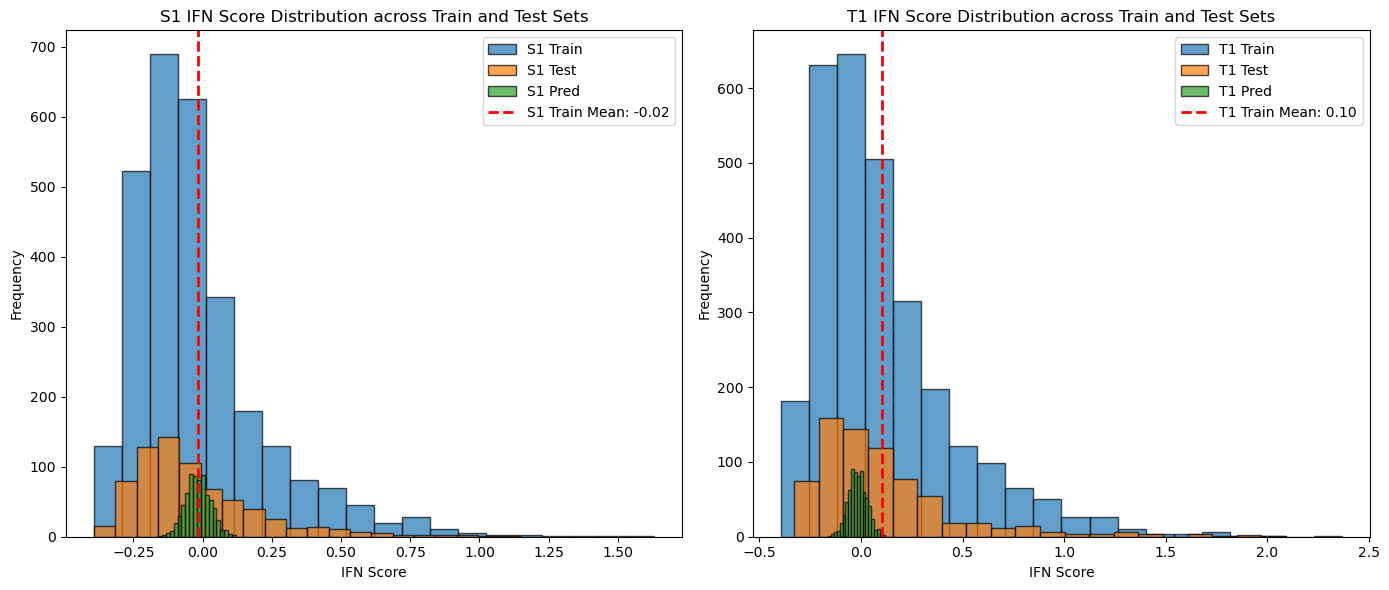

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the means of the distributions
mean_s1_train = np.mean(y_s1_train)

mean_t1_train = np.mean(y_t1_train)

# Plot IFN score distributions for train and test sets
plt.figure(figsize=(14, 6))

# Train distribution
plt.subplot(1, 2, 1)
plt.hist(y_s1_train, bins=20, alpha=0.7, label="S1 Train", edgecolor="black")
plt.hist(y_s1_test, bins=20, alpha=0.7, label="S1 Test", edgecolor="black")
plt.hist(y_s1_pred, bins=20, alpha=0.7, label="S1 Pred", edgecolor="black")
plt.axvline(mean_s1_train, color='red', linestyle='dashed', linewidth=2, label=f"S1 Train Mean: {mean_s1_train:.2f}")
plt.title("S1 IFN Score Distribution across Train and Test Sets")
plt.xlabel("IFN Score")
plt.ylabel("Frequency")
plt.legend()

# Test distribution
plt.subplot(1, 2, 2)
plt.hist(y_t1_train, bins=20, alpha=0.7, label="T1 Train", edgecolor="black")
plt.hist(y_t1_test, bins=20, alpha=0.7, label="T1 Test", edgecolor="black")
plt.hist(y_t1_pred, bins=20, alpha=0.7, label="T1 Pred", edgecolor="black")
plt.axvline(mean_t1_train, color='red', linestyle='dashed', linewidth=2, label=f"T1 Train Mean: {mean_t1_train:.2f}")
plt.title("T1 IFN Score Distribution across Train and Test Sets")
plt.xlabel("IFN Score")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()
